## Enterprise Data Science subject part 4 solution

## SIR modelling and Visualising in DASH Framework of COVID 19 Data

In [1]:
# add necessary imports
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 1000)


In [2]:
import os
if os.path.split(os.getcwd())[-1]=='notebooks':
    os.chdir("../")

'Your base path is at: '+os.path.split(os.getcwd())[-1]

'Your base path is at: Enterprise-Data-Science-Submissions'

## Dataset for analysis


In [3]:
#Read the data
df_analyse=pd.read_csv('data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse = df_analyse.drop(columns={'Unnamed: 0'})
df_analyse.sort_values('date',ascending=True).head()

,date,US,India,Germany,Italy,Australia
0,2020-01-22,1,0,0,0,0
1,2020-01-23,1,0,0,0,0
2,2020-01-24,2,0,0,0,0
3,2020-01-25,2,0,0,0,0
4,2020-01-26,5,0,0,0,4


## SIR Model

In [4]:
## Nice mathematical explanation of the differential SIR 
# https://www.youtube.com/watch?v=NKMHhm2Zbkw

# mathematical model that shows how a disease can spread over a certain period.

# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [5]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

## Simulative approach to calculate SIR curves

In [6]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

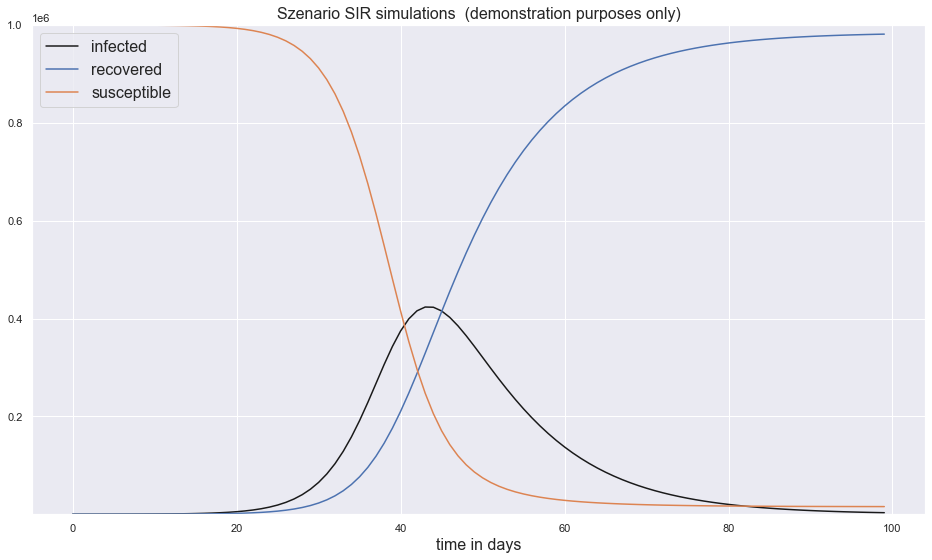

In [7]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [8]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt


In [9]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [10]:
def fit_and_predict(country):
    print("Country:",country)
    ydata = np.array(df_analyse[country][40:150])
    t=np.arange(len(ydata))
    
    # ensure re-initialization 
    # attenion when slicing out only a time window 
    # (one Corana wave) the overall N0 is not the full popoulation size 
    N0=10000000

    I0=ydata[0]
    S0=N0-I0
    R0=0
    print('start infected:',I0)
    print('cumulative sum of invected after period',ydata[-1])
    print('Number of days',len(ydata))
    print('N0',N0)
    
    
    ## get the model parameters / fit the model
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))

    print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

    # get the final fitted curve / predict the outcome 
    fitted=fit_odeint(t, *popt)
    return fitted

Country: Germany
start infected: 150
cumulative sum of invected after period 188534
Number of days 110
N0 10000000


C:\Users\Dheeraj\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Dheeraj\AppData\Local\Temp/ipykernel_2848/1568337494.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\Dheeraj\AppData\Local\Temp/ipykernel_2848/1568337494.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\Dheeraj\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00474012 0.00447228]  start infect: 150
Optimal parameters: beta = 0.22986384048721342  and gamma =  0.0885326272406866
Basic Reproduction Number R0  2.5963743271991797


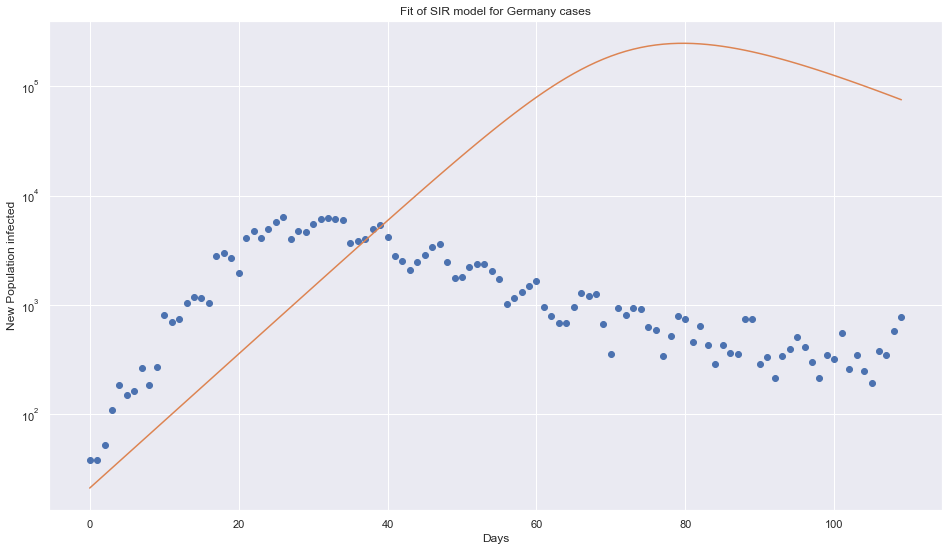

In [11]:
ydata = np.array(df_analyse['Germany'][40:150])
t=np.arange(len(ydata))
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fit_and_predict('Germany'))

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
#print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
#print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
#print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

## Visualise the SIR model for COVID-19 first wave(approx dates) using dynamic dash library

In [16]:
import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

countries_list=['Germany','Italy', 'US','India','Australia']

fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    ##  This visualisation contains SIR modelling for first wave of COVID 19(mid Jan to mid May of 2021).
    
    SIR model is used to predict the spread of a certain disease using infection rate (beta) and recovery rate (gamma) over entire population.

    '''),

    dcc.Markdown('''
    ### Select Country for visualization of SIR Model prediction
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in countries_list],
        value='Germany', # which is pre-selected
        multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope')
])



@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country):

    my_yaxis={'type':"log",
                  'title':'Population infected and SIR model prediction (source johns hopkins csse, log-scale)'
              }


    traces = []    
    traces.append(dict(x=df_analyse.date, #t,
                            y=df_analyse[country][40:150],
                            mode='markers+lines',
                            opacity=0.9,
                            name='actual covid infections'
                    )
            ),
    traces.append(dict(x=df_analyse.date, #t, 
                        y=fit_and_predict(country),
                        mode='markers+lines',
                        opacity=0.6,
                        name='SIR model predictions for covid infections'
                )
        )
    

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
